In [1]:
import sys
sys.path.insert(0, '../backend')
sys.path.insert(0, '../../data')

In [2]:
import numpy as np
import time
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

import pybnb
from transformers import *
from fbm import FBM

from generalized_dtw import Warp
from branch_and_bound_warped_pvar import BnBWarping

In [3]:
dist = 'eucl'

if dist == 'eucl':
    # Euclidean
    d = lambda a, b: (a-b)**2
    f_d = lambda DD, a, b: np.sqrt(DD**2 + d(a, b))
    final_operator = lambda x: np.sqrt(x)

elif dist == 'manh':
    # Manhattan
    d = lambda a, b : np.abs(a-b)
    f_d = lambda DD, a, b: DD + d(a,b)
    final_operator = lambda x: x
    
else:
    # Minkowksi
    d = lambda a, b : np.abs(a-b)
    f_d = lambda DD, a, b: max(DD, d(a,b))
    final_operator = lambda x: x

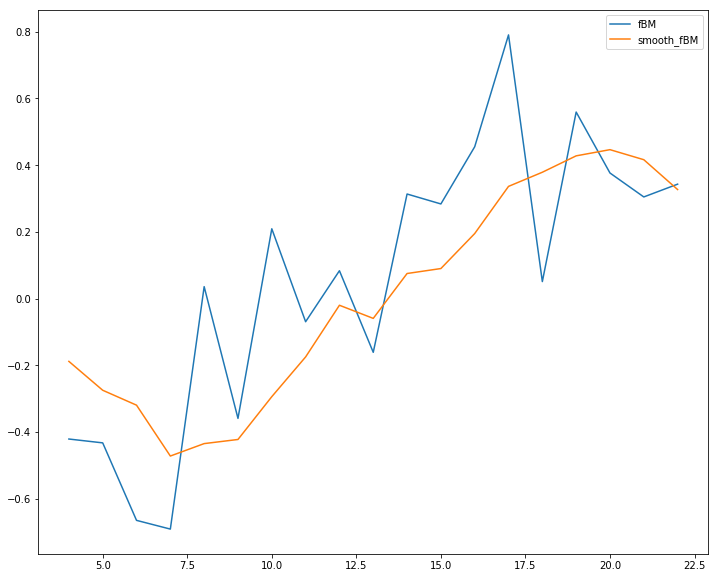

In [13]:
fbm_generator = FBM(n=22, hurst=0.3, length=1)
fbm_sample = fbm_generator.fbm()
fbm_sample_smooth = pd.Series(fbm_sample).rolling(window=5).mean()
df = pd.DataFrame([fbm_sample, fbm_sample_smooth], index=['fBM', 'smooth_fBM']).T.dropna()
df.plot(figsize=(12, 10))
plt.show()

# DTW

In [5]:
W = Warp(df.fBM.values, df.smooth_fBM.values, d, f_d, final_operator)

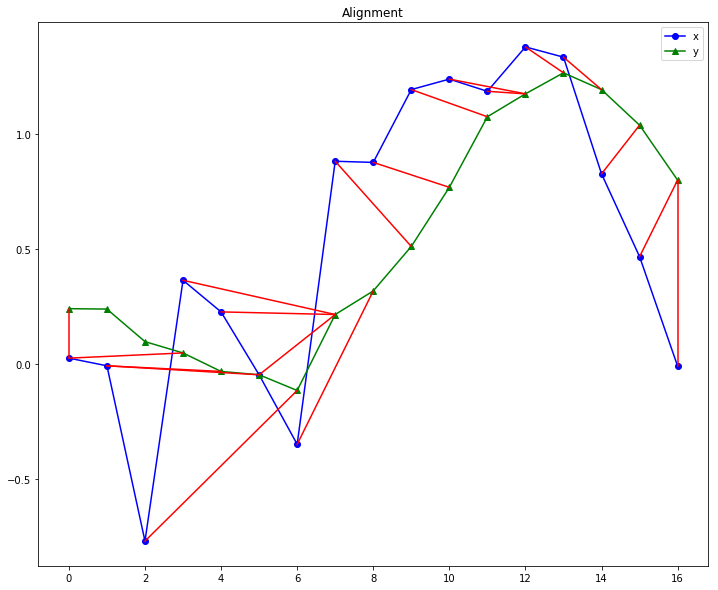

In [11]:
plt.figure(figsize=(12, 10))
W.plot_alignment()

In [14]:
W = Warp(df.fBM.values, df.smooth_fBM.values, d, f_d, final_operator)

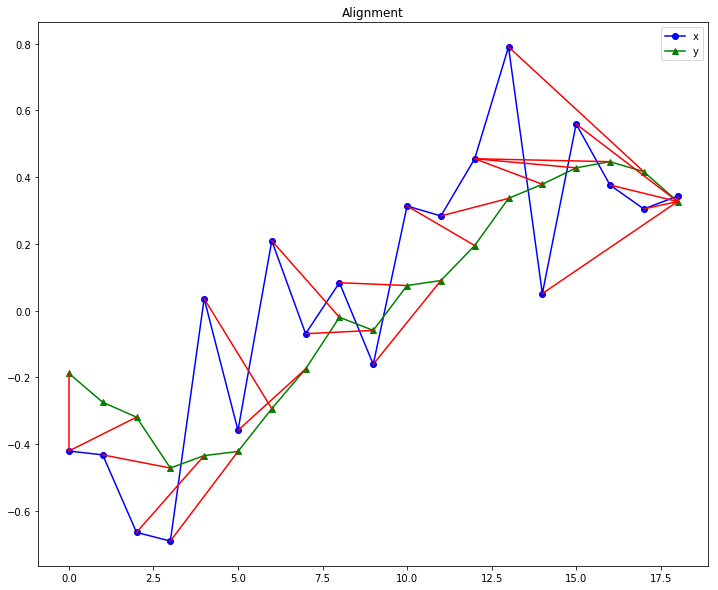

In [15]:
plt.figure(figsize=(12, 10))
W.plot_alignment()

# Warped rough p-var distance

In [8]:
x = AddTime().fit_transform([df.fBM.values])[0]
y = AddTime().fit_transform([df.smooth_fBM.values])[0]

warped p-var: 3.87
wall time: 6297.29 secs 

best_warp: [(0, 0), (0, 1), (1, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 7), (4, 8), (5, 8), (6, 8), (7, 9), (8, 10), (9, 11), (10, 12), (11, 13), (12, 13), (13, 13), (14, 14), (15, 15), (16, 16)] 



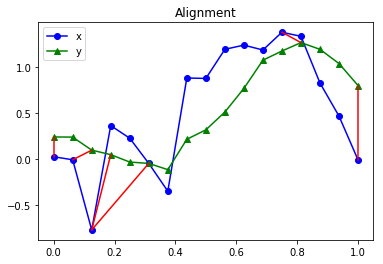

In [9]:
problem = BnBWarping(x=x, y=y, p=2.1, depth=2, norm='l1', root_node=(0, 0), bc=3, cache_size=1024,
                     plot_2d=True, record_path=False, pvar_dist_mem=None, pvar_mem_org=None, 
                     initial_time=None, use_bound1=True, use_bound2=True, use_bound3=True)

solver = pybnb.Solver()

results = solver.solve(problem, log=None, queue_strategy='depth')

print('warped p-var: {:.2f}'.format(results.objective))
print('wall time: {:.2f} secs \n'.format(results.wall_time))

best_warp = results.best_node.state
print('best_warp: {} \n'.format(best_warp[1:]))
_, optimal_partition = problem.distance(results.best_node.state, optim_partition=True)
problem.plot_alignment([best_warp[k] for k in optimal_partition])
plt.show()

In [ ]:
problem = BnBWarping(x=x, y=y, p=2.7, depth=2, norm='l1', root_node=(0, 0), bc=4, cache_size=2048,
                     plot_2d=True, record_path=False, pvar_dist_mem=None, pvar_mem_org=None, 
                     initial_time=None, use_bound1=True, use_bound2=True, use_bound3=True)

solver = pybnb.Solver()

results = solver.solve(problem, log=None, queue_strategy='depth')

print('warped p-var: {:.2f}'.format(results.objective))
print('wall time: {:.2f} secs \n'.format(results.wall_time))

best_warp = results.best_node.state
print('best_warp: {} \n'.format(best_warp[1:]))
_, optimal_partition = problem.distance(results.best_node.state, optim_partition=True)
problem.plot_alignment([best_warp[k] for k in optimal_partition])
plt.show()